# Prosit Project Part III
## 3. Tranfer Learning
> ##### 3.a. Imports and Loading the trained model (from scratch)
> ##### 3.b. Train specific layers of the base model with Dongxue Dataset (Training & Validation)
> ##### 3.c. Test with the Dongxue Holdout
> ##### 3.d. Report

In [1]:
!nvidia-smi

Thu Oct 14 15:28:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000035:03:00.0 Off |                    0 |
| N/A   33C    P0    39W / 300W |      0MiB / 32510MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### 3.a. Imports and Loading the trained model (from scratch)

In [2]:
import dlpro
from dlpro import constants, data, eval, layers, models, pipelines, reports, utils
import tensorflow as tf
from dlpro.eval.rt_eval import delta95_metric
from dlpro.eval.rt_eval import TimeDeltaMetric
from dlpro.data.RetentionTimeDataset import RetentionTimeDataset
from dlpro.models.prosit import PrositRetentionTimePredictor
from dlpro.reports.RetentionTimeReport import RetentionTimeReport

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from matplotlib.offsetbox import AnchoredText
# from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline

# Wassim's density plot requirements
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator

# Saving the history as dict and pandas df
import pickle

In [9]:
def density_plot(predictions, experimental, header = "title", nbins = 1000):
    
    matplotlib.rcParams["axes.titlepad"] = 25
    matplotlib.rcParams["axes.labelpad"] = 10
    
    df = pd.DataFrame({"predictions" : np.ravel(predictions), "test_targets" : np.ravel(experimental)})

    H, xedges, yedges = np.histogram2d(df["predictions"],df["test_targets"], bins=nbins) # df[x] yerine df["predictions"] kullan, predictions -> x yerine
    H = np.rot90(H)
    H = np.flipud(H)
    Hmasked = np.ma.masked_where(H==0,H) 
    cm = plt.cm.get_cmap('RdYlBu')
    
    plt.figure(figsize = (7,10))    
    plt.pcolormesh(xedges, yedges, Hmasked, cmap = cm, norm = LogNorm(1e0,1e1))
    
    plt.xlabel("iRT (measured)", fontsize = 20)  # part is excluded:"\n Epochs : {}\n{}\n{}".format(len(Histdf), report_str_1,report_str_2)
    plt.ylabel("iRT (predicted)",  fontsize = 20)
    plt.title(header, fontsize = 24)
    
    cbar = plt.colorbar( ticks = LogLocator(subs = range(10)))
    cbar.ax.set_ylabel('Counts', fontsize = 20)
    cbar.ax.tick_params(labelsize = 20)
    cbar.ax.minorticks_on()
    
    a = np.percentile(np.abs(df["predictions"] - df["test_targets"]), 95)
    b = np.mean(np.abs(df["predictions"] - df["test_targets"]))
    
    plt.text(-2,109,"R-squared = {:.3f}\nn = {:3d}\nDelta 95 = {:.3f}\nMean Error = {:.3f}".format(r2_score(df["test_targets"], df["predictions"]) , len(df["test_targets"]), a, b), 
             fontsize = 14, bbox = dict(facecolor = "m", alpha = 0.3, boxstyle = "round"))
    
    plt.plot([0, 120], [0, 120], ls = "--", linewidth = "2", color = "black", label= "Diagonal") 
    # plt.plot([0, 120], [3, 123], color = "black", label= "upper 95%")
    # plt.plot([0, 120], [-3, 117], color = "green", label= "lower 95%")
    plt.legend(loc=4, prop={"size": 14})
    
    plt.savefig("./Ekin_plots/{} Density Plot.png".format(header), bbox_inches="tight", pad_inches = 1, dpi = 300, transparent= None)

In [3]:
SEQ_LENGTH = 30

In [5]:
TL_TRAIN_DATAPATH = "/scratch/dongxue_tissue_0.01FDR/dongxue_P013129_irt_train_data.csv"
DONGXUE_TEST_DATAPATH = "/scratch/dongxue_tissue_0.01FDR/dongxue_P013129_irt_holdout_data.csv"

rtdata = RetentionTimeDataset(data_source=TL_TRAIN_DATAPATH,
                              pad_length=SEQ_LENGTH, batch_size=1024, val_ratio=0.25, test=False, sample_run=False)

test_rtdata = RetentionTimeDataset(data_source = DONGXUE_TEST_DATAPATH,
                              pad_length=30, batch_size=64, test=True)

In [6]:
weights_file_path = "transfer_learning" 
loss_format = "{val_loss:.5f}"
epoch_format = "{epoch:02d}"
weights_file = "{}/weight_{}_{}".format(
    weights_file_path, epoch_format, loss_format
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(weights_file, save_best_only=True, save_weights_only=True)
decay = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, verbose=1, min_lr=0)
early_stop = tf.keras.callbacks.EarlyStopping(patience=10)
callbacks = [checkpoint, early_stop, decay]

### 3.b. Freeze & Training

In [7]:
tl_model = PrositRetentionTimePredictor(seq_length = SEQ_LENGTH)

In [8]:
tl_model.load_weights("./prosit_ekin_training_best_checkpoint")

In [9]:
deneme_predictions = tl_model.predict(test_rtdata.test_data)

In [10]:
deneme_predictions = deneme_predictions.ravel()

In [11]:
deneme_predictions = rtdata.denormalize_targets(deneme_predictions)

In [12]:
deneme_test_targets = test_rtdata.get_split_targets(split="test")

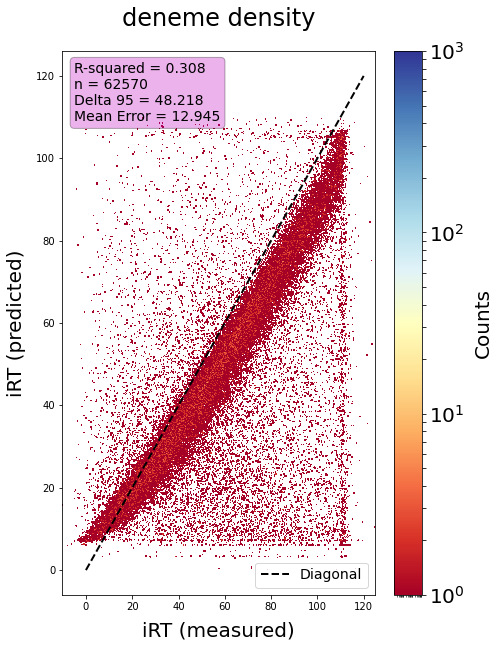

In [14]:
density_plot(deneme_predictions,deneme_test_targets,header="deneme density")

In [37]:
tl_model.summary()

Model: "prosit_retention_time_predictor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
string_lookup (StringLookup) multiple                  0         
_________________________________________________________________
embedding (Embedding)        multiple                  352       
_________________________________________________________________
sequential (Sequential)      (None, 30, 512)           1996800   
_________________________________________________________________
attention_layer (AttentionLa multiple                  542       
_________________________________________________________________
sequential_1 (Sequential)    (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              multiple                  513       
Total params: 2,260,863
Trainable params: 262,656
Non-trainable params: 1,998,207
___________________

In [16]:
layers = tl_model.layers

In [35]:
n = 4

In [36]:
print("name:",layers[n])
print("weights:", len(layers[n].weights))
print("trainable_weights:", len(layers[n].trainable_weights))
print("non_trainable_weights:", len(layers[n].non_trainable_weights))

name: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7ffe5127eb90>
weights: 2
trainable_weights: 2
non_trainable_weights: 0


In [26]:
for i in range(0,6):
    tl_model.layers[i].trainable = False 

In [27]:
tl_model.layers[4].trainable = True

In [38]:
optimizer = tf.keras.optimizers.Adam(lr=0.0001, decay=1e-7)

In [39]:
tl_model.compile(optimizer="adam", 
              loss="mean_squared_error",
              metrics=["mean_absolute_error", TimeDeltaMetric(rtdata.data_mean, rtdata.data_std)]) 

In [40]:
tl_model_history = tl_model.fit(rtdata.train_data, validation_data=rtdata.val_data, 
                                       epochs=100, callbacks=callbacks)

Epoch 1/100
184/184 [==============================] - 45s 225ms/step - loss: 0.5957 - mean_absolute_error: 0.4713 - timedelta: 28.6280 - val_loss: 0.4578 - val_mean_absolute_error: 0.3718 - val_timedelta: 21.9202
Epoch 2/100
184/184 [==============================] - 40s 218ms/step - loss: 0.4483 - mean_absolute_error: 0.3676 - timedelta: 22.6736 - val_loss: 0.4062 - val_mean_absolute_error: 0.3446 - val_timedelta: 20.3969
Epoch 3/100
184/184 [==============================] - 41s 221ms/step - loss: 0.4065 - mean_absolute_error: 0.3479 - timedelta: 21.3092 - val_loss: 0.3849 - val_mean_absolute_error: 0.3416 - val_timedelta: 20.3818
Epoch 4/100
184/184 [==============================] - 41s 221ms/step - loss: 0.3886 - mean_absolute_error: 0.3460 - timedelta: 20.4137 - val_loss: 0.3752 - val_mean_absolute_error: 0.3448 - val_timedelta: 20.6000
Epoch 5/100
184/184 [==============================] - 41s 221ms/step - loss: 0.3795 - mean_absolute_error: 0.3485 - timedelta: 20.3041 - val_lo

184/184 [==============================] - 40s 217ms/step - loss: 0.3568 - mean_absolute_error: 0.3550 - timedelta: 18.8777 - val_loss: 0.3517 - val_mean_absolute_error: 0.3514 - val_timedelta: 21.0158
Epoch 78/100
184/184 [==============================] - 41s 220ms/step - loss: 0.3562 - mean_absolute_error: 0.3545 - timedelta: 19.0461 - val_loss: 0.3516 - val_mean_absolute_error: 0.3514 - val_timedelta: 21.0132
Epoch 79/100
184/184 [==============================] - 41s 220ms/step - loss: 0.3564 - mean_absolute_error: 0.3546 - timedelta: 19.2337 - val_loss: 0.3516 - val_mean_absolute_error: 0.3512 - val_timedelta: 21.0060
Epoch 80/100
184/184 [==============================] - 40s 218ms/step - loss: 0.3560 - mean_absolute_error: 0.3544 - timedelta: 19.5203 - val_loss: 0.3515 - val_mean_absolute_error: 0.3514 - val_timedelta: 21.0179
Epoch 81/100
184/184 [==============================] - 40s 218ms/step - loss: 0.3560 - mean_absolute_error: 0.3547 - timedelta: 18.6828 - val_loss: 0.35

In [43]:
# save the history as a data frame in a .csv file for further use, if possible
pd.DataFrame.from_dict(tl_model_history.history).to_csv("./TransferLearningHistoryDataFrame",index=False)

In [44]:
Histdf = pd.read_csv("./TransferLearningHistoryDataFrame")

In [45]:
Histdf

,loss,mean_absolute_error,timedelta,val_loss,val_mean_absolute_error,val_timedelta,lr
0,0.536024,0.429812,25.206453,0.457846,0.371804,21.920204,1.000000e-06
1,0.431772,0.358885,21.023905,0.406228,0.344631,20.396906,1.000000e-06
2,0.398608,0.345507,19.885168,0.384901,0.341643,20.381754,1.000000e-06
3,0.383403,0.345028,19.087523,0.375219,0.344762,20.600004,1.000000e-06
4,0.376200,0.348063,18.979904,0.370604,0.348854,20.830034,1.000000e-06
...,...,...,...,...,...,...,...
95,0.354512,0.352766,18.280090,0.350390,0.350131,20.931007,1.000000e-06
96,0.354299,0.352507,18.191059,0.350329,0.350187,20.931606,1.000000e-06
97,0.354264,0.352610,18.195196,0.350273,0.350085,20.924921,1.000000e-06
98,0.354337,0.352720,18.212605,0.350216,0.350081,20.922382,1.000000e-06


In [46]:
add_to_report = Histdf.iloc[[-1]]

In [47]:
first_three = add_to_report[["loss", "mean_absolute_error","timedelta"]]

In [48]:
last_three = add_to_report[["val_loss", "val_mean_absolute_error","val_timedelta"]]

In [49]:
report_str_1 = first_three.to_string(index = False)

In [50]:
report_str_2 = last_three.to_string(index = False)

In [51]:
print("Epochs:",len(Histdf),"\n{}\n{}".format(report_str_1, report_str_2))

Epochs: 100 
    loss  mean_absolute_error  timedelta
0.354113             0.352584  18.100576
 val_loss  val_mean_absolute_error  val_timedelta
 0.350162                 0.349955      20.913406


### 3.c. Test with the Dongxue Holdout

In [77]:
tl_predictions = tl_model.predict(test_rtdata.test_data)

In [78]:
tl_predictions = tl_predictions.ravel()

In [79]:
tl_predictions = rtdata.denormalize_targets(tl_predictions)

In [80]:
tl_predictions

array([50.072346, 17.37009 , 67.80155 , ..., 82.55119 , 57.229103,
       32.658768], dtype=float32)

In [81]:
test_targets = test_rtdata.get_split_targets(split="test")

In [82]:
test_targets

array([51.864, 18.743, 74.705, ..., 78.172, 62.335, 28.386])

In [3]:
density_plot(tl_predictions, test_targets, header = "Transfer Learning Model Test with Dongxue Holdout\n(sequential_1 layer only)")

NameError: name 'tl_predictions' is not defined

### Troubleshooting for abnormal predictions

In [117]:
test_sequences = test_rtdata.sequences 

In [118]:
test_sequences

array(['GVIPPEVGNVAVR', 'YPKEDSEIR', 'WQPLYLEIR', ...,
       'IYPTVNCQPLGMISLMK', 'DGMSHLIQSAGLGGLK', 'SGEVFDKDLCK'],
      dtype=object)

In [98]:
df = pd.DataFrame({"dongxue_sequences":test_sequences,"dongxue_pred":tl_predictions, "dongxue_exp":test_targets})

In [99]:
df

,dongxue_sequences,dongxue_pred,dongxue_exp
0,GVIPPEVGNVAVR,50.072346,51.864
1,YPKEDSEIR,17.370090,18.743
2,WQPLYLEIR,67.801552,74.705
3,AELAHSPLPAK,25.757629,25.874
4,DGSDPYQEPK,16.412926,20.151
...,...,...,...
62565,ASITSSASLWHHCEHR,33.030495,26.392
62566,QHLVEAETWAWGAGHGGQGR,42.248253,28.812
62567,IYPTVNCQPLGMISLMK,82.551193,78.172
62568,DGMSHLIQSAGLGGLK,57.229103,62.335


In [125]:
error = np.abs(df["dongxue_pred"]-df["dongxue_exp"])

In [128]:
type(error)

pandas.core.series.Series

In [129]:
df["abs_error"] = error

In [131]:
df

,dongxue_sequences,dongxue_pred,dongxue_exp,abs_error
0,GVIPPEVGNVAVR,50.072346,51.864,1.791654
1,YPKEDSEIR,17.370090,18.743,1.372910
2,WQPLYLEIR,67.801552,74.705,6.903448
3,AELAHSPLPAK,25.757629,25.874,0.116371
4,DGSDPYQEPK,16.412926,20.151,3.738074
...,...,...,...,...
62565,ASITSSASLWHHCEHR,33.030495,26.392,6.638495
62566,QHLVEAETWAWGAGHGGQGR,42.248253,28.812,13.436253
62567,IYPTVNCQPLGMISLMK,82.551193,78.172,4.379193
62568,DGMSHLIQSAGLGGLK,57.229103,62.335,5.105897


In [132]:
sequences=df["dongxue_sequences"]

In [133]:
s=sequences.str.len()

In [134]:
df["seq_length"] = s

In [138]:
seq_length_sorted = df.sort_values(["abs_error"], ascending=True)

In [139]:
seq_length_sorted

,dongxue_sequences,dongxue_pred,dongxue_exp,abs_error,seq_length
36359,APIDTPTQQLIQDIK,64.475624,64.476,0.000376,15
12724,TYYESVR,22.432371,22.433,0.000629,7
58556,ILSIPSEVEMQCTLR,67.568771,67.568,0.000771,15
41502,EQNLQDIK,21.968801,21.968,0.000801,8
50177,QLCEQAPSTSVLLLSPQPMGK,70.193665,70.195,0.001335,21
...,...,...,...,...,...
59610,RIHIGQKPRT,18.755457,105.520,86.764543,10
30662,SSACQKGAHPGWHSHENQDM,19.117769,106.130,87.012231,20
12684,VGNSAGQSLNKPNIHKR,17.730371,105.170,87.439629,17
4161,KMEDNRGCGCSSDTGK,14.489685,105.980,91.490315,16


### 3.d. Test with Original Data

In [67]:
TEST_DATAPATH = "/scratch/train_ekin/new_holdout_data.csv" # test with original ho set 

test_rtdata = RetentionTimeDataset(data_source = TEST_DATAPATH,
                              pad_length=30, batch_size=64, test=True)


TRAIN_DATAPATH = "/scratch/train_ekin/new_train_data.csv" # for denormalizing the test_targets

rtdata = RetentionTimeDataset(data_source=TRAIN_DATAPATH,
                              pad_length=SEQ_LENGTH, batch_size=1024, val_ratio=0.25, test=False, sample_run=False)


In [68]:
tl_predictions = tl_model.predict(test_rtdata.test_data)

In [69]:
tl_predictions = tl_predictions.ravel()

In [70]:
tl_predictions = rtdata.denormalize_targets(tl_predictions)

In [71]:
tl_predictions

array([80.59841 , 35.222836, 90.584145, ..., 29.106403, 65.46553 ,
       78.1072  ], dtype=float32)

In [72]:
test_targets = test_rtdata.get_split_targets(split="test")

In [73]:
test_targets

array([106.85361792,  53.66648129, 111.97376267, ...,  43.88259566,
        81.972167  , 110.08648948])

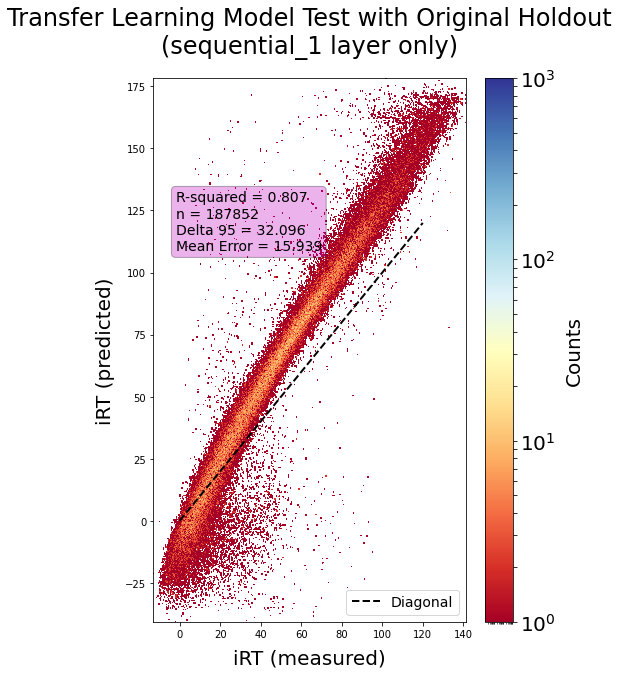

In [74]:
density_plot(tl_predictions, test_targets, header = "Transfer Learning Model Test with Original Holdout\n(sequential_1 layer only)")